# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [11]:
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import scipy
import torch

sns.set_theme()

In [3]:
from subpair import extract, pairwise_cosine

# Setup

In [17]:
img_folder = Path("../higherANML/experiments/data/ImageNet84")
feats_folder = Path("/users/l/f/lfrati/scratch/OmnImage_data/torchvision.models.vgg_ce631fc9ca0278a2")
cls2label = {}
with open(img_folder / "imagenet_class_index.json") as f:
    class_idx = json.load(f)
    cls2label = dict(class_idx.values())

In [42]:
all_feature_files = sorted(feats_folder.iterdir())
imgcls_file = all_feature_files[0]
imgcls = imgcls_file.stem
print(f"Working with class: {imgcls} ({cls2label[imgcls]})")

Working with class: n01440764 (tench)


In [50]:
X = np.load(imgcls_file)

In [51]:
distances = pairwise_cosine(X)

In [52]:
num_samples = 750
best, stats = extract(distances, P=200, S=num_samples, K=50, M=3, O=2, its=3000)

100%|██████████| 3000/3000 [05:32<00:00,  9.01it/s]


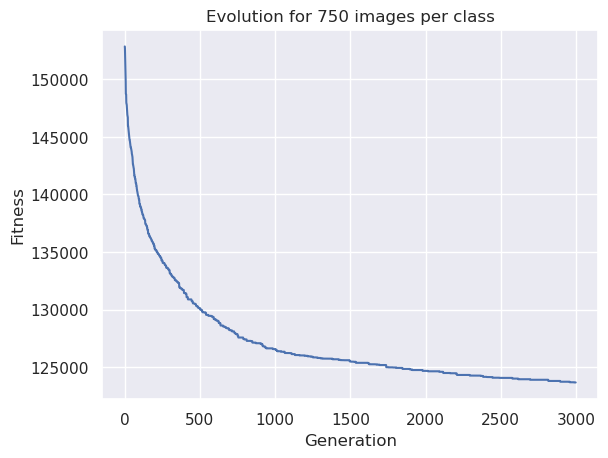

In [53]:
plt.plot(stats["fits"])
plt.xlabel("Generation")
plt.ylabel("Fitness")
_ = plt.title(f"Evolution for {num_samples} images per class")

# Single Class Analysis

In [90]:
imgcls_file = np.random.choice(all_feature_files)
imgcls = imgcls_file.stem
print(f"Computing image distances for class: {imgcls} ({cls2label[imgcls]})")
X = np.load(imgcls_file)
distances = pairwise_cosine(X)

Computing image distances for class: n04355933 (sunglass)


In [91]:
sample_sizes = [10, 20, 50, 100, 200, 500]
results = []
for i, num_samples in enumerate(sample_sizes):
    best, stats = extract(distances, P=200, S=num_samples, K=50, M=3, O=2, its=3000)
    results.append({"num_samples": num_samples, "best": best, "stats": stats})

100%|██████████| 3000/3000 [00:33<00:00, 90.24it/s]


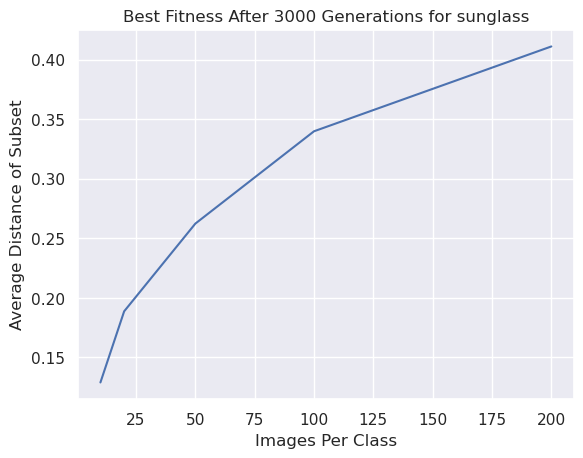

In [92]:
final_fitnesses = [r["stats"]["fits"][-1] / ((N*(N-1))/2) for N, r in zip(sample_sizes, results)]
plt.plot(sample_sizes, final_fitnesses)
plt.xlabel("Images Per Class")
plt.ylabel("Average Distance of Subset")
_ = plt.title(f"Best Fitness After 3000 Generations for {cls2label[imgcls]}")

# Aggregating Multiple Classes

In [95]:
import itertools


def compute_evolved_subsets(distances, sample_sizes=None):
    if not sample_sizes:
        sample_sizes = [10, 20, 50, 100, 200, 500]
    results = []
    for i, num_samples in enumerate(sample_sizes):
        best, stats = extract(distances, P=200, S=num_samples, K=50, M=3, O=2, its=3000)
        results.append({"num_samples": num_samples, "best": best, "stats": stats})
    return results


def compute_evolved_distances_for_class(imgcls_file, sample_sizes):
    imgcls = imgcls_file.stem
    print(f"Computing evolved subsets for class: {imgcls} ({cls2label[imgcls]})")
    X = np.load(imgcls_file)
    distances = pairwise_cosine(X)
    avg_dists = compute_evolved_subsets(distances, sample_sizes)
    return [r["stats"]["fits"][-1] / ((N*(N-1))/2) for N, r in zip(sample_sizes, avg_dists)]


def get_fitnesses_for_classes(num_classes=None):
    if num_classes is None:
        cls_files = all_feature_files
    else:
        cls_files = np.random.choice(all_feature_files, size=num_classes, replace=False)

    sample_sizes = [10, 20, 50, 100, 200]
    records = []
    for f in cls_files:
        clsid = f.stem
        clsname = cls2label[clsid]
        dists = compute_evolved_distances_for_class(f, sample_sizes)
        records.extend(zip(itertools.repeat(clsid), itertools.repeat(clsname), sample_sizes, dists))
    
    return pd.DataFrame.from_records(records, columns=("Class ID", "Label", "Subset Size", "Avg. Dist."))

In [96]:
df = get_fitnesses_for_classes(10)

Computing evolved subsets for class: n02113023 (Pembroke)


100%|██████████| 3000/3000 [00:33<00:00, 90.57it/s]


Computing evolved subsets for class: n03930313 (picket_fence)


100%|██████████| 3000/3000 [00:34<00:00, 88.03it/s]


Computing evolved subsets for class: n02167151 (ground_beetle)


100%|██████████| 3000/3000 [00:33<00:00, 89.98it/s]


Computing evolved subsets for class: n02279972 (monarch)


100%|██████████| 3000/3000 [00:33<00:00, 90.29it/s]


Computing evolved subsets for class: n02219486 (ant)


100%|██████████| 3000/3000 [00:33<00:00, 88.84it/s]


Computing evolved subsets for class: n02777292 (balance_beam)


100%|██████████| 3000/3000 [00:33<00:00, 90.10it/s]


Computing evolved subsets for class: n03903868 (pedestal)


100%|██████████| 3000/3000 [00:33<00:00, 90.12it/s]


Computing evolved subsets for class: n03344393 (fireboat)


100%|██████████| 3000/3000 [00:33<00:00, 88.65it/s]


Computing evolved subsets for class: n04239074 (sliding_door)


100%|██████████| 3000/3000 [00:33<00:00, 90.34it/s]


Computing evolved subsets for class: n01694178 (African_chameleon)


100%|██████████| 3000/3000 [00:33<00:00, 89.93it/s]


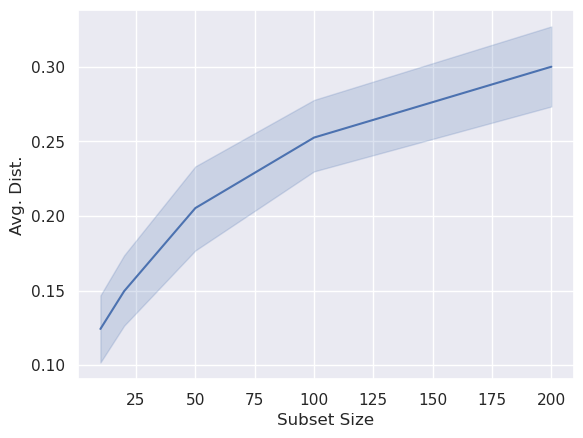

In [98]:
_ = sns.lineplot(data=df, x="Subset Size", y="Avg. Dist.")#, hue="Label")

In [94]:
dists = df.loc[df["Subset Size"] == 200]["Avg. Dist."]
print(f"{dists.mean()}, {dists.std()}")
final_fitnesses

0.40645819429177144, 5.851389114294502e-17


[0.12901785108778213,
 0.1887407604016756,
 0.2623825633769133,
 0.3398962279040404,
 0.41111652010050254]